In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time

from tensorflow.python.keras.utils.version_utils import training
from tqdm import tqdm

X = np.load('x_letters.npy')
y = np.load('y_letters.npy')

X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)

y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)
batch_size = 64
img_size = 28
n_class = 26
noise_dim = 500
epoch_count = 10000

mask = tf.logical_and(y_tensor > 17, y_tensor < 22)

X_filtered = tf.boolean_mask(X_tensor, mask)
y_filtered = tf.boolean_mask(y_tensor, mask)

dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)
print(len(X_tensor))
print(len(X_filtered))


88799
13669


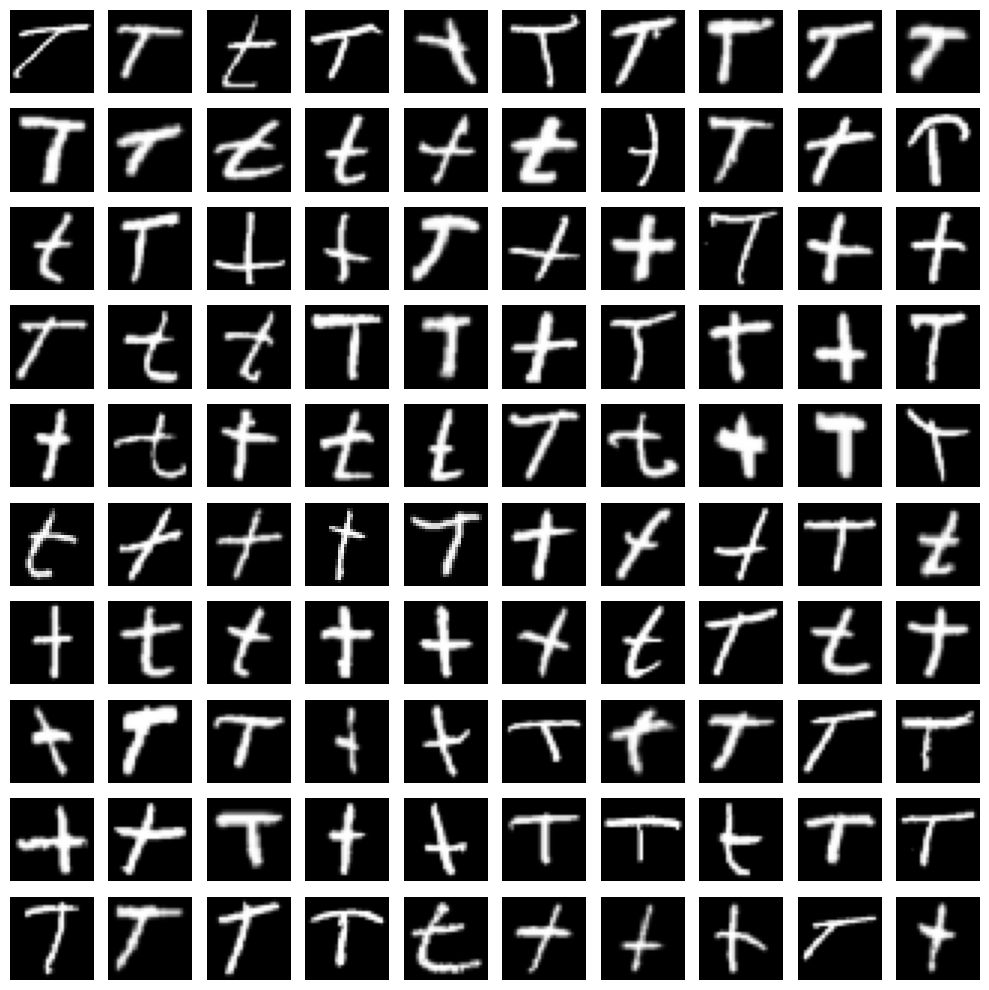

In [18]:
indices = tf.where(y_tensor == 19)[:, 0]

# Select the first 100 indices (in case there are more than 100)
indices = indices[:100]

# Gather the images corresponding to these indices
selected_images = tf.gather(X_tensor, indices)

# Plot them in a 10x10 grid
plt.figure(figsize=(10, 10))
for i in range(len(indices)):
    plt.subplot(10, 10, i + 1)
    # Each image is 28x28x1 — squeeze to (28,28) for plotting
    plt.imshow(tf.squeeze(selected_images[i]), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
bce_loss = tf.keras.losses.BinaryCrossentropy()


def discriminator_loss(real, fake):
    real_labels = tf.ones_like(real)
    fake_labels = tf.zeros_like(fake)

    real_loss = bce_loss(real_labels, real)
    fake_loss = bce_loss(fake_labels, fake)

    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(preds, generated_images, real_images, epoch,
                   base_adv_weight=0.0, l1_weight=0.0, ssim_weight=10.0,
                   adv_growth=0.0, decay=10.00):
    adv_loss = bce_loss(tf.ones_like(preds), preds)

    l1_loss = tf.reduce_mean(tf.abs(generated_images - real_images))

    ssim_score = tf.image.ssim(
        tf.expand_dims(generated_images, -1),
        tf.expand_dims(real_images, -1),
        max_val=1.0
    )
    ssim_loss = 1.0 - tf.reduce_mean(ssim_score)

    adv_weight = base_adv_weight * (1 + adv_growth * epoch)
    l1_weight = l1_weight - decay * epoch
    l1_weight = max(l1_weight, 0.0)
    ssim_weight = ssim_weight - decay * epoch
    ssim_weight = max(ssim_weight, 0.0)
    adv_weight = max(adv_weight, 1.0)
    if epoch == 0:
        adv_weight = 0.0

    total_loss = adv_weight * adv_loss + l1_weight * l1_loss + ssim_weight * ssim_loss

    return total_loss


d_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.001, beta_1=0.5)

In [20]:
from tensorflow.keras import layers, Sequential


class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.net1 = Sequential([layers.Dense(14 * 14 * 64, activation='leaky_relu'),
                                layers.Dense(14 * 14 * 64, activation='leaky_relu'),
                                ])
        self.conv = Sequential([layers.Conv2D(filters=64, kernel_size=(3, 3), activation='leaky_relu', padding="same"),
                                layers.Dropout(0.3),
                                layers.UpSampling2D((2, 2)),
                                layers.Conv2D(filters=32, kernel_size=(3, 3), activation='leaky_relu', padding="same"),
                                layers.Dropout(0.3),
                                layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding="same"), ])

        #self.conv = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")

    def call(self, noise, labels):
        x = tf.concat([noise, labels], axis=1)
        x = self.net1(x)
        x = tf.reshape(x, (-1, 14, 14, 64))
        x = self.conv(x)
        #x = self.conv(tf.reshape(x, [-1, 28, 28, 1]))
        x = tf.reshape(x, [-1, 28, 28])
        return x


g_model = Generator()

In [21]:
class Descriminator(tf.keras.Model):
    def __init__(self):
        super(Descriminator, self).__init__()

        self.conv_layers = Sequential([
            layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(),
            layers.Dropout(0.4),
            layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(),
            layers.Dropout(0.4),
        ])

        self.dense = Sequential([
            layers.Dense(128, activation="leaky_relu"),
            layers.Dropout(0.4),
            layers.Dense(64, activation="leaky_relu"),
            layers.Dropout(0.4),
        ])
        self.out_real_classifier = layers.Dense(1)

    def call(self, x, labels):
        x = tf.expand_dims(x, -1)
        x = self.conv_layers(x)
        x = tf.reshape(x, [x.shape[0], -1])
        x = tf.concat([x, labels], axis=1)
        x = self.dense(x)
        reality_logits = self.out_real_classifier(x)
        return reality_logits


import tensorflow as tf
from tensorflow.keras import layers, Sequential


class PTDescriminator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv_layers = Sequential([
            layers.Conv2D(128, 4, strides=1, padding="same"),
            layers.LeakyReLU(),
            layers.Conv2D(128, 4, strides=1, padding="same"),
            layers.Dropout(0.3),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2D(128, 4, strides=1, padding="same"),
            layers.Dropout(0.3),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2D(1, 4, padding="same", strides=1)  # output patch map
        ])

    def call(self, x, labels):
        x = tf.expand_dims(x, -1)
        # Optionally add label conditioning
        x = self.conv_layers(x)
        return x  # shape [batch, h', w', 1]

d_model = PTDescriminator()

In [22]:
@tf.function
def train_step(dataset):
    batch_size = tf.shape(dataset[0])[0]
    real_images, real_labels = dataset
    real_labels = tf.one_hot(real_labels, depth=n_class)
    real_labels = tf.cast(real_labels, tf.float32)

    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    generated_images = g_model(random_latent_vectors, real_labels)

    with tf.GradientTape() as tape:
        pred_fake = d_model(generated_images, real_labels)
        pred_real = d_model(real_images, real_labels)

        d_loss = discriminator_loss(pred_real, pred_fake)

    grads = tape.gradient(d_loss, d_model.trainable_variables)

    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))

    with tf.GradientTape() as tape:
        fake_images = g_model(random_latent_vectors, real_labels)
        predictions = d_model(fake_images, real_labels)
        g_loss = generator_loss(predictions)

    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))

    return d_loss, g_loss


@tf.function
def train_d(real_images, real_labels):
    batch_size = tf.shape(real_images)[0]

    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    generated_images = g_model(random_latent_vectors, real_labels, training=False)

    with tf.GradientTape() as tape:
        pred_fake = d_model(generated_images, real_labels, training=True)
        pred_real = d_model(real_images, real_labels, training=True)

        d_loss = discriminator_loss(pred_real, pred_fake)

    grads = tape.gradient(d_loss, d_model.trainable_variables)

    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

    return d_loss


@tf.function
def train_g(real_labels, real_images, epoch):
    batch_size = tf.shape(real_labels)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g_model(random_latent_vectors, real_labels, training=True)
        predictions = d_model(fake_images, real_labels)
        g_loss = generator_loss(predictions, fake_images, real_images, epoch)
    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))
    return g_loss




In [23]:
import string


def generate_all_letters(generator, latent_dim, img_size=(28, 28)):
    num_letters = 26
    plt.figure(figsize=(22, 20))

    for i, letter in enumerate(string.ascii_uppercase):
        latent_vector = tf.random.normal(shape=(1, latent_dim))
        label = tf.one_hot([i], depth=26)
        generated_image = generator(latent_vector, label)

        plt.subplot(1, num_letters, i + 1)
        plt.imshow(generated_image[0], cmap='gray')
        plt.axis('off')
        plt.title(letter, fontsize=8)

    plt.tight_layout()
    plt.show()

100%|██████████| 1388/1388 [08:15<00:00,  2.80it/s]


Epoch 1/10000 | D Loss: 5.8136, G Loss: 7.2478, 


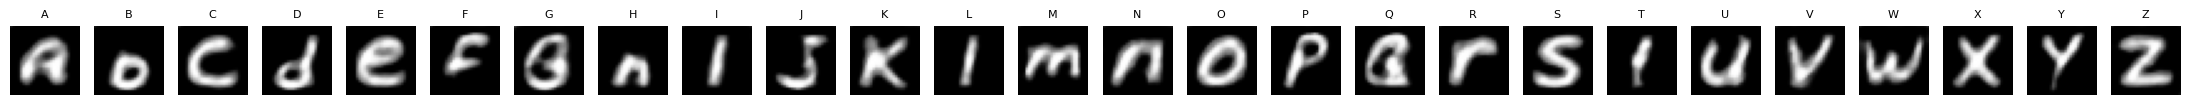

100%|██████████| 1388/1388 [06:56<00:00,  3.33it/s]


Epoch 2/10000 | D Loss: 4.9720, G Loss: nan, 


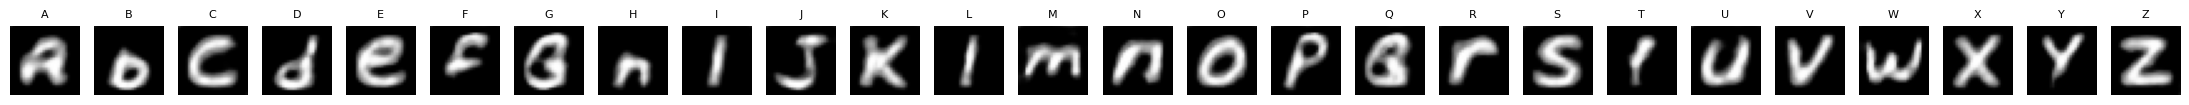

100%|██████████| 1388/1388 [05:50<00:00,  3.95it/s]


Epoch 3/10000 | D Loss: 1.7121, G Loss: 0.4171, 


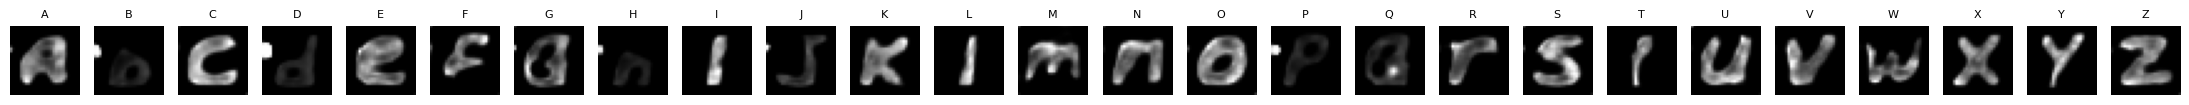

100%|██████████| 1388/1388 [05:49<00:00,  3.97it/s]


Epoch 4/10000 | D Loss: 1.3581, G Loss: 0.2920, 


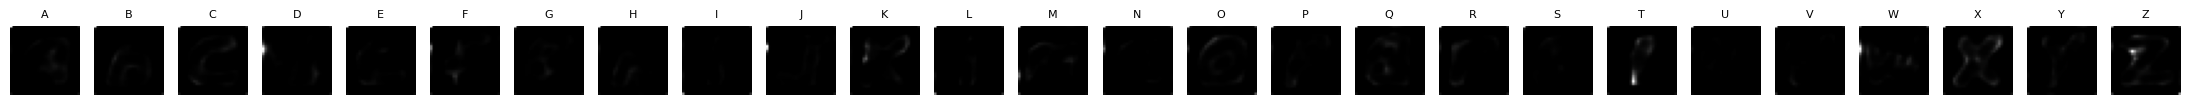

100%|██████████| 1388/1388 [05:46<00:00,  4.00it/s]


Epoch 5/10000 | D Loss: 1.3440, G Loss: 0.4601, 


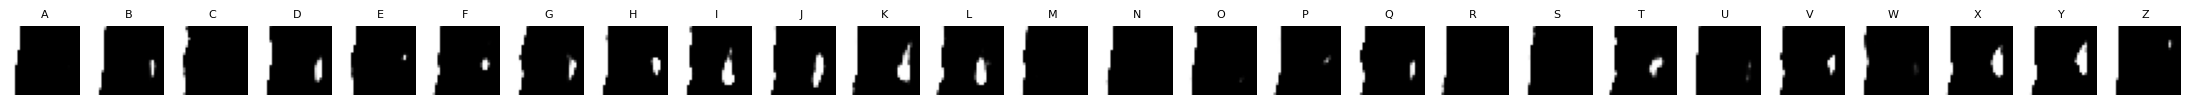

100%|██████████| 1388/1388 [05:49<00:00,  3.98it/s]


Epoch 6/10000 | D Loss: 0.7393, G Loss: 0.3042, 


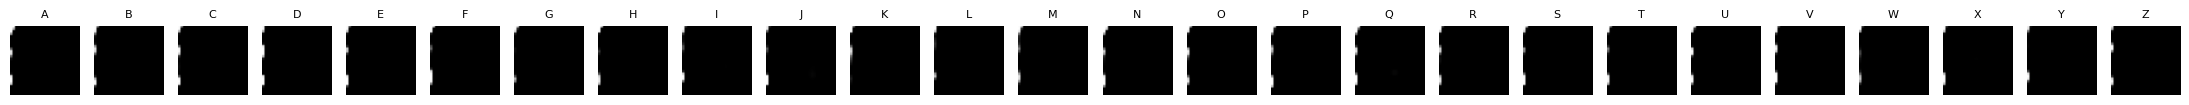

100%|██████████| 1388/1388 [05:52<00:00,  3.94it/s]


Epoch 7/10000 | D Loss: 0.1949, G Loss: 0.0578, 


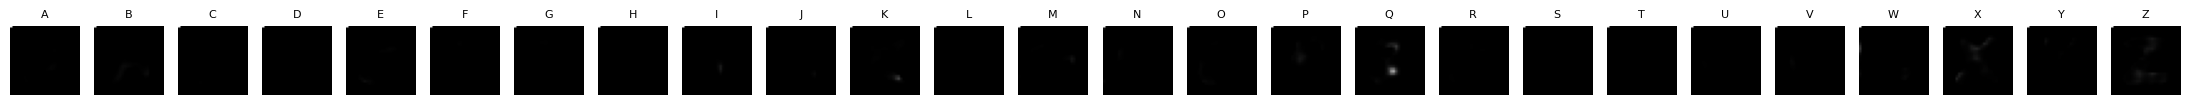

100%|██████████| 1388/1388 [05:48<00:00,  3.98it/s]


Epoch 8/10000 | D Loss: 0.0279, G Loss: 0.0208, 


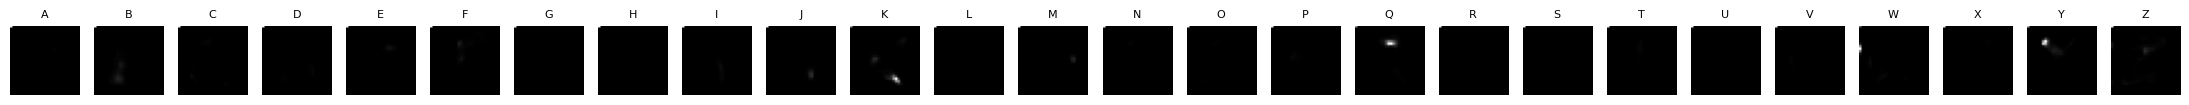

100%|██████████| 1388/1388 [05:56<00:00,  3.90it/s]


Epoch 9/10000 | D Loss: 0.0066, G Loss: 0.0196, 


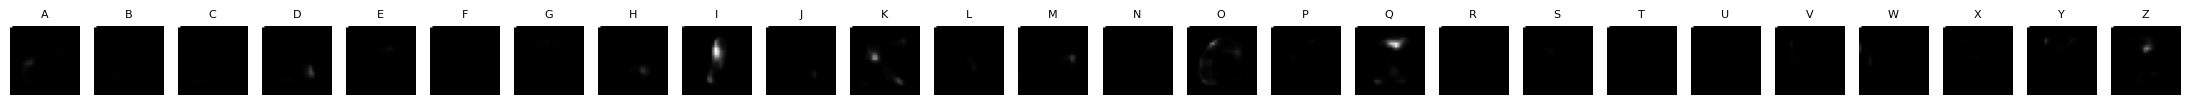

100%|██████████| 1388/1388 [05:58<00:00,  3.87it/s]


Epoch 10/10000 | D Loss: 0.0025, G Loss: 0.0131, 


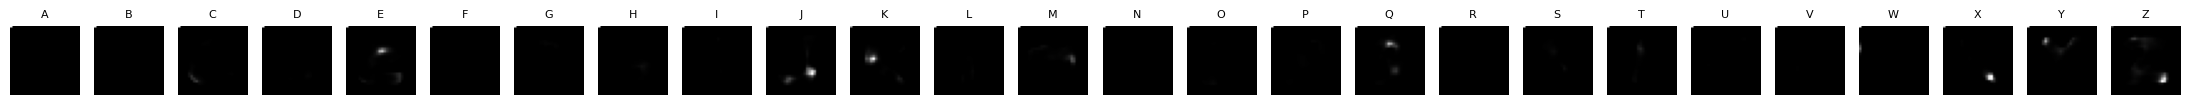

 90%|█████████ | 1252/1388 [05:24<00:35,  3.85it/s]


KeyboardInterrupt: 

In [24]:
def train(dataset, epochs=epoch_count, d_steps=100, g_steps=4):
    for epoch in range(epochs):
        d_losses = []
        g_losses = []

        if epoch == 0:
            g_steps = 2
            d_steps = 1

        if epoch == 1:
            d_steps = 2
            g_steps = 0

        if epoch == 2:
            g_steps = 1
            d_steps = 1
            g_optimizer.learning_rate = 0.00005
            d_optimizer.learning_rate = 0.0001

        for images, labels in tqdm(dataset):
            labels = tf.one_hot(labels, depth=n_class)
            labels = tf.cast(labels, tf.float32)

            for _ in range(d_steps):
                d_loss = train_d(images, labels)
                d_losses.append(d_loss)

            for _ in range(g_steps):
                g_loss = train_g(labels, images, epoch)
                g_losses.append(g_loss)

        print(f"Epoch {epoch + 1}/{epochs} | "
              f"D Loss: {tf.reduce_mean(d_losses):.4f}, "
              f"G Loss: {tf.reduce_mean(g_losses):.4f}, ")

        generate_all_letters(g_model, noise_dim)


train(dataset, epochs=epoch_count)